In [1]:
import numpy as np
import numpy.linalg as LA
import time
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

## Part 1. Generalization of Static DA

 ## Set Model Parameters & Data Distribution

In [2]:
ambientDimension = 100
sigma = 0.5 # noise power
numAvg = int(1 * 1e+2) # number of average

featureMean = np.zeros(ambientDimension)

# Isotropic data 
featureCov = np.identity(ambientDimension)
betaStar = np.random.multivariate_normal(featureMean, featureCov).reshape(-1,1)
betaStar /= LA.norm(betaStar)

# Nonisotropic data (comment this block if istropic data is used)
#featureCov = np.identity(ambientDimension)
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        featureCov[i,i] = 10
#betaStar =  np.zeros(ambientDimension).reshape(-1,1)
#betaStar[0] = 0.1
#betaStar[-1] = 1

In [6]:
# Auxillary functions
def getRidgeEst(X, y, yc, ridge):
    d = X.shape[1]
    n = X.shape[0]
    S = LA.inv(X.T.dot(X) + n*ridge*np.identity(d)).dot(X.T)
    return S.dot(y), S.dot(yc)

def getCropEst(X, y, yc, p):
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    Z = (1-p) * Cov + p * diag  
    S = LA.inv(Z).dot(X.T)
    return S.dot(y), S.dot(yc) 

def getFiniteCropEst(X, y, yc, k, p):
    mean_mask = getMask(k, p)
    Xb = X * mean_mask
    Cov_a = Xb.T.dot(Xb)
    Cov_a -= np.diag(np.diag(Cov_a))
    Cov = X.T.dot(X)
    diag = np.diag(Cov)
    diag = diag * mean_mask
    diag = np.diag(diag)
    Z = Cov_a + diag  
    S = LA.inv(Z).dot(Xb.T)
    return S.dot(y), S.dot(yc)

def getProjEst(X, y, yc, k):
    Cov = X.T.dot(X)
    d = X.shape[1]
    Z = (k+1)/d*Cov + 1/d*np.trace(Cov)*np.identity(d)
    S = LA.inv(Z).dot(X.T)
    return S.dot(y), S.dot(yc)

def getMixProjEst(X, y, k, a):
    Cov = X.T.dot(X)
    d = X.shape[1]
    Z = ((1-a)**2 + 2*a*(1-a)*k/d +a**2*(k**2+k)/d**2) * Cov
    Z += a**2*k/d**2*np.trace(Cov)*np.identity(d)
    est = LA.inv(Z).dot((1-a + a*k/d) * X.T.dot(y))
    return est

def getMixupEst(X, y, a):
    Cov = X.T.dot(X)
    n = X.shape[0]
    #d = X.shape[1]
    sumData = X.sum(axis=0).reshape(-1,1)
    sumY = y.sum()
    Z = (a+1)/(2*a+1)*Cov + a/(2*a+1)/n*sumData.dot(sumData.T)# + np.identity(d)
    Z1 = (a+1)/(2*a+1)*X.T.dot(y) + a/(2*a+1)/n*sumData*sumY
    return LA.pinv(Z).dot(Z1)

def getMixOTEst(X, y, a, P):
    Cov = X.T.dot(X)
    n = X.shape[0]
    Z = (a+1)/(2*a+1)/n*Cov + a/(4*a+2)*X.T.dot(P+P.T).dot(X)
    Z1 = (a+1)/(2*a+1)/n*X.T.dot(y) + a/(4*a+2)*X.T.dot(P+P.T).dot(y)
    return LA.pinv(Z).dot(Z1)

def getMask(k, p):
    mean_mask = 0
    for i in range(k):
        mean_mask += bernoulli.rvs(1-p, size=ambientDimension)
    return mean_mask / k

def sinkhornIter(K, niter):
    n = K.shape[0]
    ones = np.ones(n) / n
    a = np.ones(n) / n
    b = np.ones(n) / n
    for i in range(niter):
        b = ones / K.T.dot(a).reshape(-1)
        a = ones / K.dot(b).reshape(-1)
    return np.diag(a).dot(K).dot(np.diag(b))

def getLSEst(X, y, yc):
    Cov = X.T.dot(X)
    #d = X.shape[1]
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X.T)
    return S.dot(y), S.dot(yc)

def getRisk(betaTrue, betaEmp, noiseStd):
    mean = featureMean.reshape(-1,1)
    diff = betaTrue-betaEmp
    risk1 = diff.T.dot(featureCov + mean.dot(mean.T)).dot(diff)
    return risk1# + noiseStd**2    

def getExpRisk(numSampling, numIter, paraList, modeDA):
    risk = np.zeros([numIter, len(paraList)])
    variance = np.zeros([numIter, len(paraList)])
    bias = np.zeros([numIter, len(paraList)])
    riskLSE = np.zeros(numIter)
    biasLSE = np.zeros(numIter)
    varianceLSE = np.zeros(numIter)
            
    for t in range(numIter):
        # Draw training data
        X = np.random.multivariate_normal(featureMean, featureCov, numSampling)
        yc = X.dot(betaStar)
        y = yc + np.random.normal(0, sigma, numSampling).reshape(-1,1)
        # baseline LSE
        betaEst, betaEstClean = getLSEst(X, y, yc)
        riskLSE[t] = getRisk(betaStar, betaEst, sigma)
        biasLSE[t] = getRisk(betaStar, betaEstClean, sigma)
        varianceLSE[t] = getRisk(betaEst, betaEstClean, sigma)
        # OT matching
        if modeDA == "mixOT":
            epsilon = 1e-1
            cost_matrix = np.sum(np.power(X.reshape([X.shape[0], 1, X.shape[1]]) -
                                      X.reshape([1, X.shape[0], X.shape[1]]),
                                      2), axis=-1)
            K = np.exp(-cost_matrix/epsilon)
            #K = np.random.normal(0, 1, [numSampling,numSampling])
            K = abs(K)
            P = sinkhornIter(K, 100)  
            
        for j in range(len(paraList)):
            # getEst
            if modeDA == "ridge":
                betaEst, betaEstClean = getRidgeEst(X, y, yc, paraList[j]) # Ridge est/Gaussin noise
            elif modeDA == "crop":
                betaEst, betaEstClean  = getCropEst(X, y, yc, paraList[j]) # Crop aug est
            elif modeDA == "crop_finite":
                betaEst, betaEstClean = getFiniteCropEst(X, y, yc, paraList[j], 0.2) # Crop aug est
            elif modeDA == "proj":
                betaEst, betaEstClean = getProjEst(X, y, yc, paraList[j]) # Proj aug est
            elif modeDA == "mixproj":
                betaEst = getMixProjEst(X, y, round(ambientDimension/10), paraList[j]) # Mix proj aug est
            elif modeDA == "mixup":
                betaEst = getMixupEst(X, y, paraList[j]) # Mixup aug
            elif modeDA == "mixOT":
                betaEst = getMixOTEst(X, y, paraList[j], P) # OT + Mixup aug
            # calculate risk
            risk[t, j] = getRisk(betaStar, betaEst, sigma)
            bias[t, j] = getRisk(betaStar, betaEstClean, sigma)
            variance[t, j] = getRisk(betaEst, betaEstClean, sigma)
    return risk.mean(axis=0), bias.mean(axis=0), variance.mean(axis=0),\
            riskLSE.mean(), biasLSE.mean(), varianceLSE.mean()

## Set augmentation parameters

In [7]:
# Choose the type of augmentation:
mode = "crop"

# set range of parameters of DA
# "crop_finite": dropout with k fixed patterns, "crop": dropout with p dropout rate, 
# "ridge": add gaussian with power sigma s^2, "proj": random projection with k dimensional space,
# "mixup": mix-up with beta distribution parameter b
if mode == "ridge":
    params = np.power(2, np.linspace(-20, 20, 20))
elif mode == "crop":
    params = np.power(2, np.linspace(-8, -1.5 , 10))
elif mode == "crop_finite":
    params = np.power(10, np.linspace(1, 2, 5)).astype(int)
elif mode == "proj":
    lowD = ambientDimension * (1-np.power(2, np.linspace(-4, -0.1 , 10)))
    params = [round(num) for num in lowD]
elif mode == "mixproj":
    params = np.power(2, np.linspace(-8, -1.5 , 10))
elif mode == "mixup":
    params = np.power(2, np.linspace(-3, 5 , 10))
elif mode == "mixOT":
    params = np.power(2, np.linspace(-3, 5 , 10))

## Simulate generalization error

In [8]:
sample = range(5, 100, 4)
riskList = list()
biasList = list()
varList = list()
riskLseList = list()
biasLseList = list()
varLseList = list()


# Simulate risk
np.random.seed(1)
count = 0
start = time.time()
for i in sample:
    riskList.append(getExpRisk(i, numAvg, params, mode)[0])
    biasList.append(getExpRisk(i, numAvg, params, mode)[1])
    varList.append(getExpRisk(i, numAvg, params, mode)[2])
    riskLseList.append(getExpRisk(i, numAvg, params, mode)[3])
    biasLseList.append(getExpRisk(i, numAvg, params, mode)[4])
    varLseList.append(getExpRisk(i, numAvg, params, mode)[5])
    count += 1
    print('Complete {} %'.format(round(count*100/len(sample), 1)))
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

Complete 4.2 %
Complete 8.3 %
Complete 12.5 %
Complete 16.7 %
Complete 20.8 %
Complete 25.0 %
Complete 29.2 %
Complete 33.3 %
Complete 37.5 %
Complete 41.7 %
Complete 45.8 %
Complete 50.0 %
Complete 54.2 %
Complete 58.3 %
Complete 62.5 %
Complete 66.7 %
Complete 70.8 %
Complete 75.0 %
Complete 79.2 %
Complete 83.3 %
Complete 87.5 %
Complete 91.7 %
Complete 95.8 %
Complete 100.0 %
Complete in 64.77 sec


## Draw curves

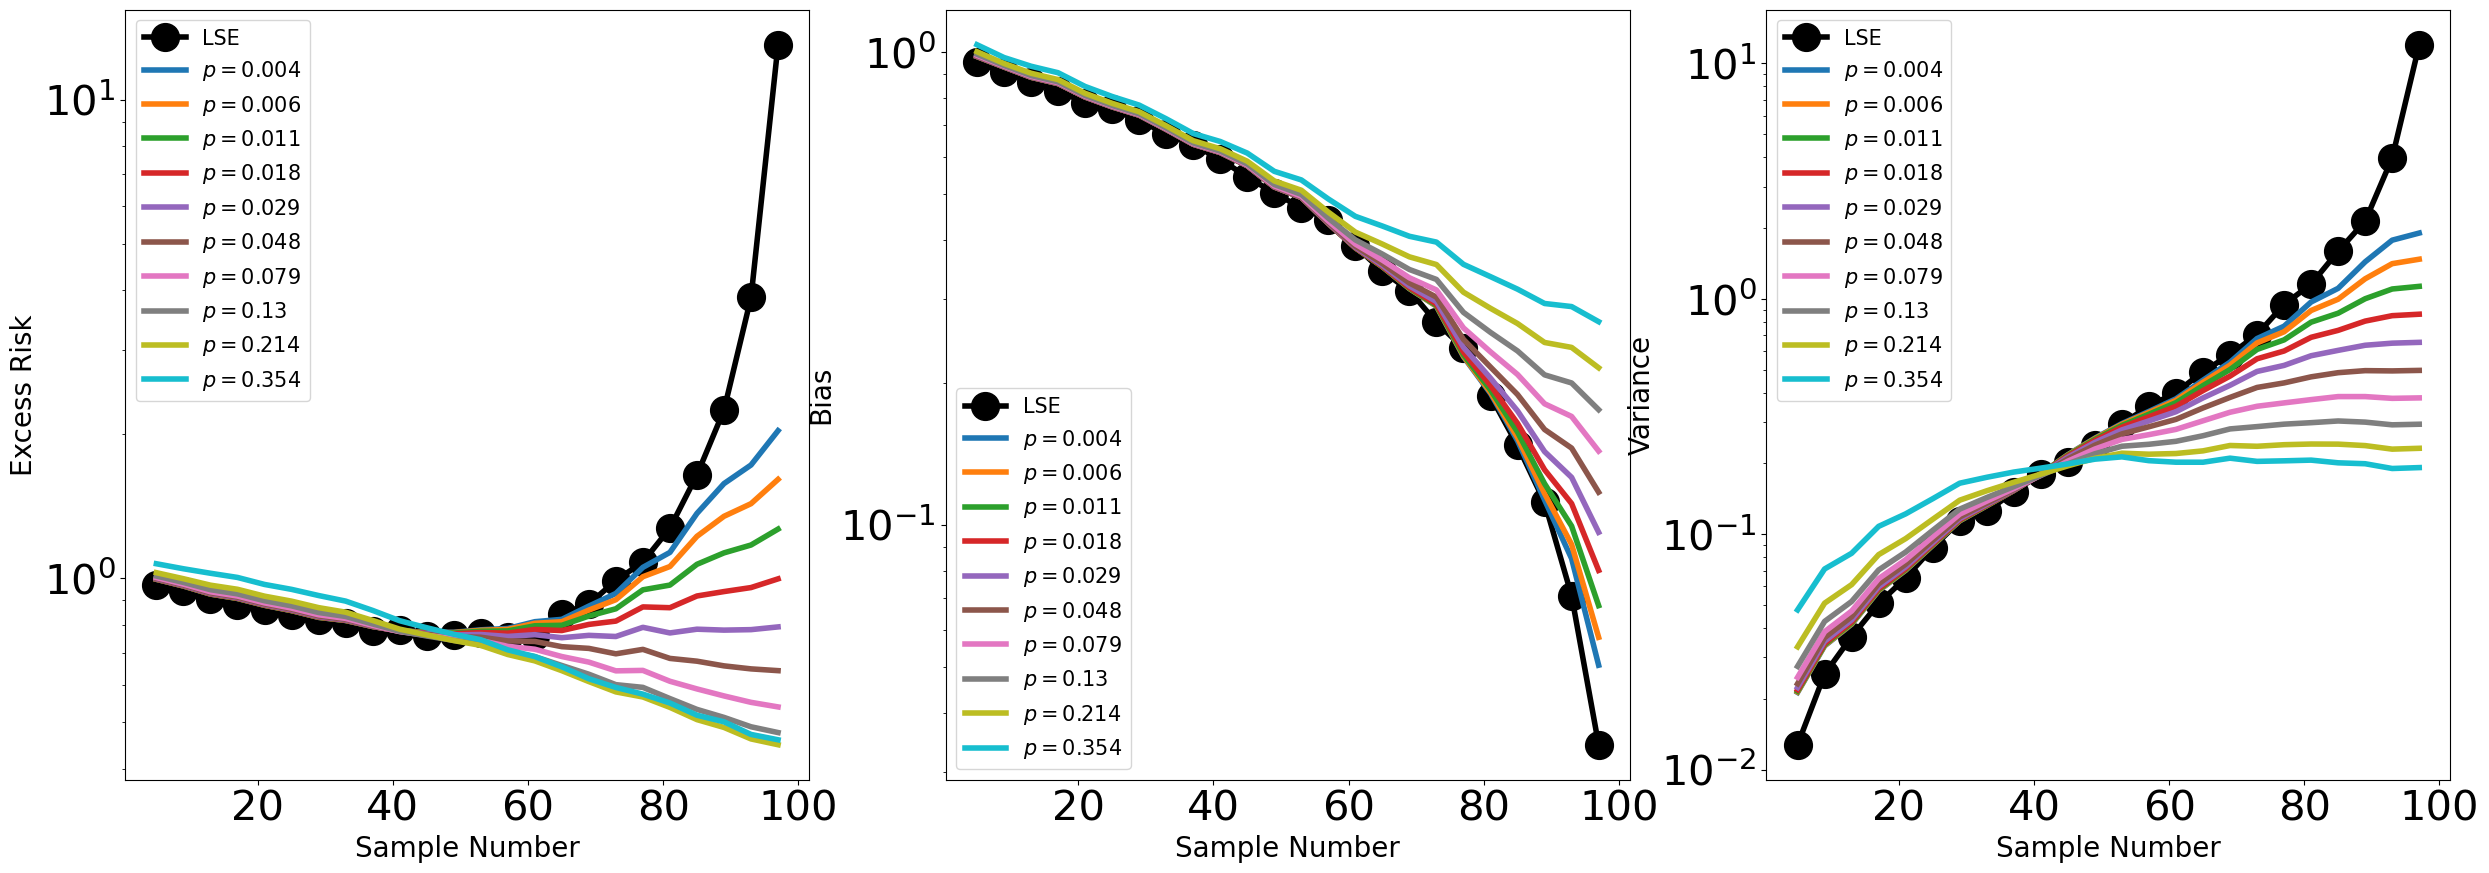

In [20]:
riskTable = np.zeros([len(sample),len(params)])
biasTable = np.zeros([len(sample),len(params)])
varTable = np.zeros([len(sample),len(params)])
for i in range(len(sample)):
    for j in range(len(params)):
        riskTable[i,j] = riskList[i][j]
        biasTable[i,j] = biasList[i][j]
        varTable[i,j] = varList[i][j]

plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
plt.plot(sample, riskLseList,label="LSE", color='black', marker='o', markersize=20, linewidth=4.0) 
for i in range(0, len(params)):
    if mode == "ridge":
        plt.plot(sample, riskTable[:,i],label=r'$\sigma=$'+str(round(np.sqrt(params[i]),3)), linewidth=4.0) # Gaussian noise
    elif mode == "crop":
        plt.plot(sample, riskTable[:,i],label=r'$p=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "crop_finite":
        plt.plot(sample, riskTable[:,i],label=r'$k=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "proj":
        plt.plot(sample, riskTable[:,i],label=r'$k=$'+str(round(params[i])), linewidth=4.0) # Random projection
    elif mode == "mixproj":
        plt.plot(sample, riskTable[:,i],label=r'$\alpha=$'+str(round(1-params[i], 3)), linewidth=4.0) # Random mixup projection    
    elif mode == "mixup":
        plt.plot(sample, riskTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # Random mixup projection 
    elif mode == "mixOT":
        plt.plot(sample, riskTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # OT + Random mixup projection
    plt.yscale("log")   
plt.legend(loc="upper left", prop={'size': 15})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Excess Risk', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.subplot(1,3,2)
plt.plot(sample, biasLseList,label="LSE", color='black', marker='o', markersize=20, linewidth=4.0) 
for i in range(0, len(params)):
    if mode == "ridge":
        plt.plot(sample, biasTable[:,i],label=r'$\sigma=$'+str(round(np.sqrt(params[i]),3)), linewidth=4.0) # Gaussian noise
    elif mode == "crop":
        plt.plot(sample, biasTable[:,i],label=r'$p=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "crop_finite":
        plt.plot(sample, biasTable[:,i],label=r'$k=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "proj":
        plt.plot(sample, biasTable[:,i],label=r'$k=$'+str(round(params[i])), linewidth=4.0) # Random projection
    elif mode == "mixproj":
        plt.plot(sample, biasTable[:,i],label=r'$\alpha=$'+str(round(1-params[i], 3)), linewidth=4.0) # Random mixup projection    
    elif mode == "mixup":
        plt.plot(sample, biasTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # Random mixup projection 
    elif mode == "mixOT":
        plt.plot(sample, biasTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # OT + Random mixup projection
    plt.yscale("log")   
plt.legend(loc="lower left", prop={'size': 15})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Bias', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.subplot(1,3,3)
plt.plot(sample, varLseList,label="LSE", color='black', marker='o', markersize=20, linewidth=4.0) 
for i in range(0, len(params)):
    if mode == "ridge":
        plt.plot(sample, varTable[:,i],label=r'$\sigma=$'+str(round(np.sqrt(params[i]),3)), linewidth=4.0) # Gaussian noise
    elif mode == "crop":
        plt.plot(sample, varTable[:,i],label=r'$p=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "crop_finite":
        plt.plot(sample, varTable[:,i],label=r'$k=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "proj":
        plt.plot(sample, varTable[:,i],label=r'$k=$'+str(round(params[i])), linewidth=4.0) # Random projection
    elif mode == "mixproj":
        plt.plot(sample, varTable[:,i],label=r'$\alpha=$'+str(round(1-params[i], 3)), linewidth=4.0) # Random mixup projection    
    elif mode == "mixup":
        plt.plot(sample, varTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # Random mixup projection 
    elif mode == "mixOT":
        plt.plot(sample, varTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # OT + Random mixup projection
    plt.yscale("log")   
plt.legend(loc="upper left", prop={'size': 15})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Variance', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

#plt.ylim(0.2,10)
plt.show()


## Part 2. DA with Gradient & Stochastic Gradient Descent

In [44]:
# Auxuilary functions
def sgd_est(Xt, yt, lr, epoch=1, DA=None):
    avgFlag = 0
    ani_rate = 1
    n, d = Xt.shape
    if DA == None:
        X = np.tile(Xt, (epoch, 1))
        y = np.tile(yt, (epoch, 1))
    elif DA["mode"] == "crop":
        p = DA["para"]
        X = np.tile(Xt, (epoch, 1))
        X = bernoulli.rvs(1-p, size=[n * epoch, d]) * X
        y = np.tile(yt, (epoch, 1))
    
    est_ini = np.zeros(d)
    # Gaussian initialization
    est_ini = np.random.multivariate_normal(np.zeros(d), np.identity(d))
    est_ini /= n**2
    estimator = np.zeros([epoch * n, d])
    ret = np.zeros([epoch, d])
    for i in range(n * epoch):
        if i % n == 0 and i > 0:
            lr *= ani_rate
        estimator[i,:] = estimator[i-1,:]  + lr * (y[i] - X[i,:].dot(estimator[i-1, :])) * X[i,:] \
            if i > 0 else est_ini  + lr * (y[i] - X[i,:].dot(est_ini)) * X[i,:]
            
    # with averaging
    if avgFlag == 1:
        estimator[0, :] = (estimator[0, :] + est_ini) / 2
        for i in range(1, n):
            estimator[i, :] = (estimator[i-1, :] * (i + 1) + estimator[i, :]) / (i + 2) 
            
    for j in range(epoch):
        ret[j, :] = estimator[(j + 1) * n - 1, :]            
    return ret

def gd_est(X, y, lr, epoch=1, DA=None):
    avgFlag = 0
    ani_rate = .5
    n, d = X.shape
    
    est_ini = np.zeros(d)
    # Gaussian initialization
    est_ini = np.random.multivariate_normal(np.zeros(d), np.identity(d))
    est_ini /= n**2
    ret = np.zeros([epoch, d])
    for i in range(epoch):
        Xt = X.copy()
        if DA == None:
            pass
        elif DA["mode"] == "crop":
            p = DA["para"]
            B = bernoulli.rvs(1-p, size=[n, d])
            Xt = B * X
        if i > 0:
            ret[i,:] = ret[i-1,:]  + lr * (Xt.T * (y - (Xt * ret[i-1,:]).sum(axis=1))).sum(axis=1) 
        else: 
            ret[i,:] = est_ini  + lr * (Xt.T * (y - (Xt * est_ini).sum(axis=1))).sum(axis=1)
            
    # with averaging
    if avgFlag == 1:
        ret[0, :] = (ret[0, :] + est_ini) / 2
        for i in range(1, epoch):
            ret[i, :] = (ret[i-1, :] * (i + 1) + ret[i, :]) / (i + 2) 
                     
    return ret

def get_sgd_risk(numAvg, modeDA,  Sampling):
    numSampling = Sampling[-1]
    lenSampling = len(Sampling)
    risk_da_sgd = np.zeros([numAvg, lenSampling, epoch])
    risk_da_gd = np.zeros([numAvg, lenSampling, epoch])
    riskLSE = np.zeros([numAvg, lenSampling])
    risk_da_exp = np.zeros([numAvg, lenSampling])
    riskLSE_sgd = np.zeros([numAvg, lenSampling, epoch])
    riskLSE_gd = np.zeros([numAvg, lenSampling, epoch])
    for t in range(numAvg):
        X = np.random.multivariate_normal(featureMean, featureCov, numSampling)
        yc = X.dot(betaStar)
        y = yc + np.random.normal(0, sigma, numSampling).reshape(-1,1)
        for j, v in enumerate(Sampling):
            betaLSE, betaLSEClean = getLSEst(X[:v, :], y[:v], yc[:v])
            riskLSE[t, j] = getRisk(betaStar, betaLSE, sigma)
            if DA["mode"]== "crop":
                betaInf, _ = getCropEst(X[:v, :], y[:v], yc[:v], DA["para"])
                risk_da_exp[t, j] = getRisk(betaStar, betaInf, sigma)
                
            # SGD based methods       
            betaEst = sgd_est(X[:v, :], y[:v], lr, epoch, DA)
            betaExp = sgd_est(X[:v], y[:v], lr, epoch)
            for k in range(epoch):
                risk_da_sgd[t, j, k] = getRisk(betaStar, betaEst[k, :].reshape(-1,1), sigma)
                riskLSE_sgd[t, j, k] = getRisk(betaStar, betaExp[k, :].reshape(-1,1), sigma)
                
            # GD based methods
            betaDA_GD = gd_est(X[:v, :], y[:v, -1], lr, epoch, DA)
            beta_GD = gd_est(X[:v], y[:v, -1], lr, epoch)
            for k in range(epoch):
                risk_da_gd[t, j, k] = getRisk(betaStar, betaDA_GD[k, :].reshape(-1,1), sigma)
                riskLSE_gd[t, j, k] = getRisk(betaStar, beta_GD[k, :].reshape(-1,1), sigma)
                
        print('Complete {} %'.format(round((t+1)*100/numAvg, 1)))
            
    return risk_da_sgd.mean(axis=0), riskLSE.mean(axis=0), risk_da_exp.mean(axis=0), riskLSE_sgd.mean(axis=0),\
        riskLSE_gd.mean(axis=0), risk_da_gd.mean(axis=0)

## Set GD Parameters

In [45]:
numAvg = int(1 * 1e+1)
lr = 10**-4
epoch = 1000
# Set DA type. Now only support dropout
DA = {"mode": "crop", "para": 0.3}     
sample = [3, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

## Run Simulation

In [46]:
start = time.time()
risk_da_sgd, riskLSE, risk_da_exp, riskLSE_sgd, \
    riskLSE_gd, risk_da_gd = get_sgd_risk(numAvg, "crop", sample)
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

Complete 10.0 %
Complete 20.0 %
Complete 30.0 %
Complete 40.0 %
Complete 50.0 %
Complete 60.0 %
Complete 70.0 %
Complete 80.0 %
Complete 90.0 %
Complete 100.0 %
Complete in 119.93 sec


## Draw GD Results

In [47]:
riskLSE_gd.shape

(11, 1000)

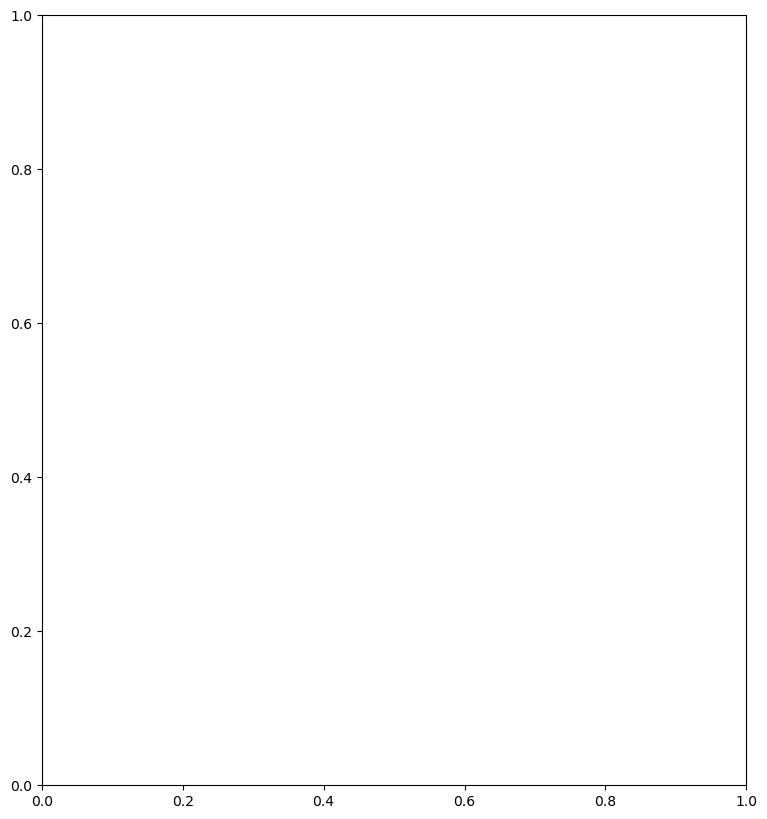

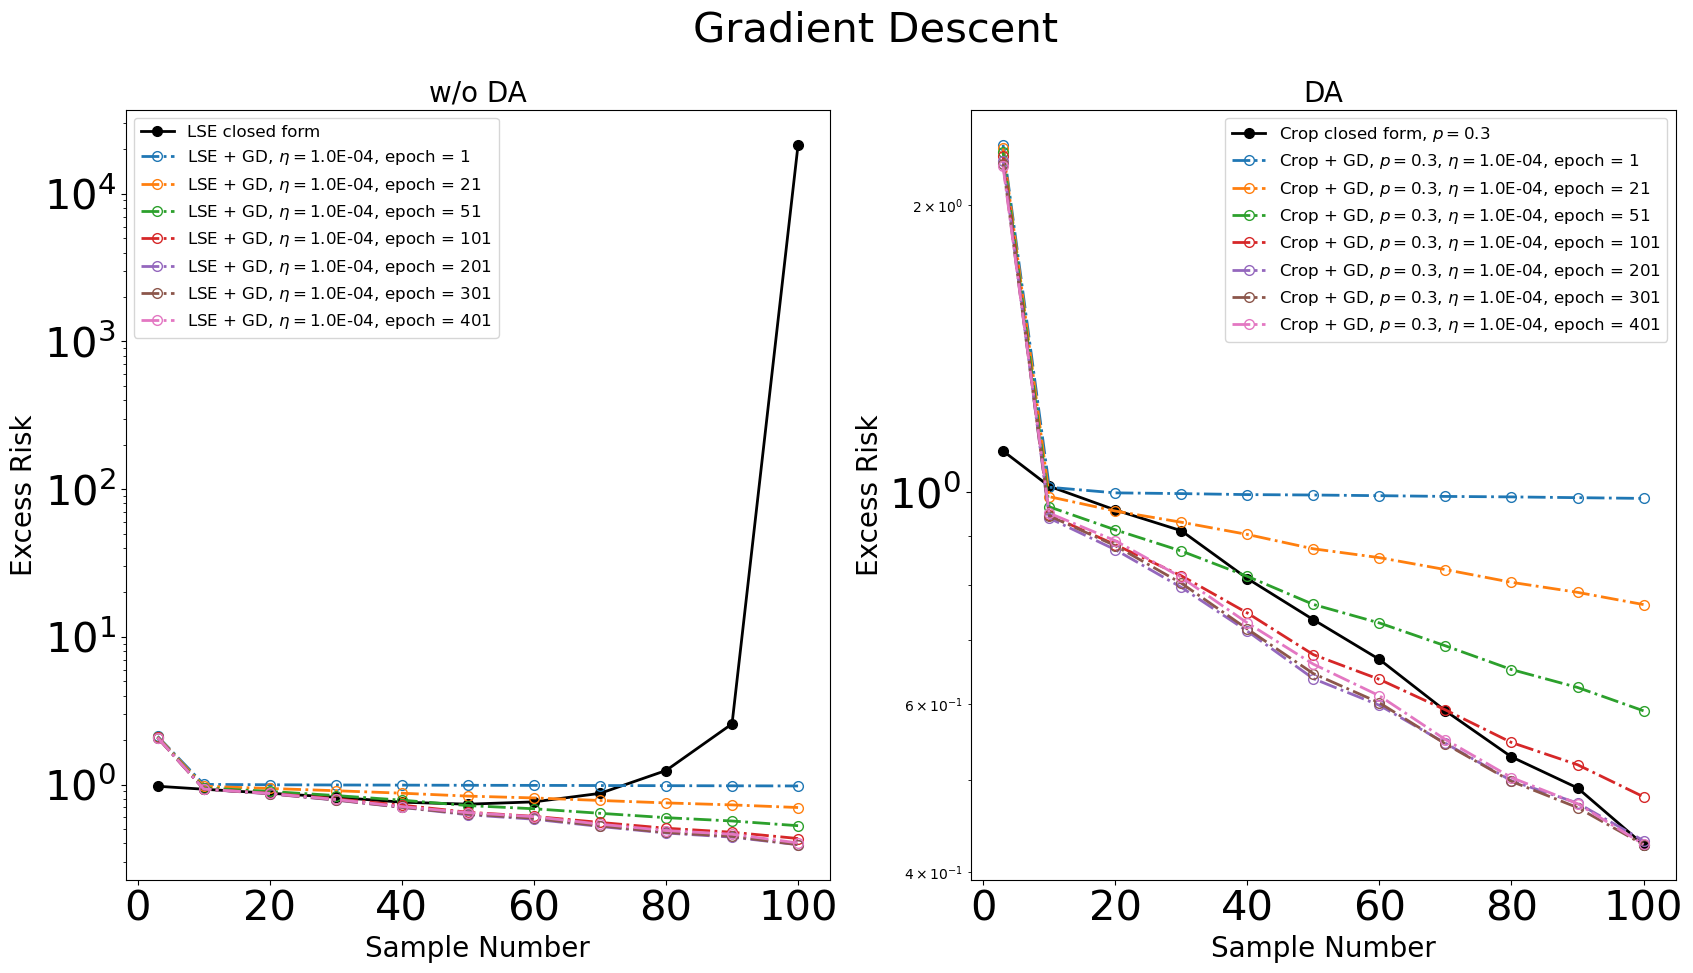

In [48]:
makersz1 = 7
makersz2 = 7
linew = 2
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(sample, riskLSE, label="LSE closed form", color='black', marker='o', markersize=  makersz1, linewidth=linew)

for k in [0, 20, 50, 100, 200, 300, 400]:
    plt.plot(sample, riskLSE_gd[:, k], label=r'LSE + GD, ' + '$\eta=$' + str(format(round(lr, 5), ".1E")) \
                 + ', epoch = ' + str(k + 1), marker='o', markersize=  makersz1, linewidth=linew, ls='dashdot', markerfacecolor='none')  
plt.legend(loc="upper left", prop={'size': 12})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Excess Risk', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.yscale("log")
plt.title('w/o DA', fontsize=20)
#plt.ylim(10**-0.3,10**.6)

plt.subplot(1, 2, 2)       
plt.plot(sample, risk_da_exp, label=r'Crop closed form, $p=$'+str(round(DA["para"],5)), marker='o', markersize=  makersz2, linewidth=linew, color='black')
for k in [0, 20, 50, 100, 200, 300, 400]:
    plt.plot(sample, risk_da_gd[:, k], label=r'Crop + GD, $p=$' + str(DA["para"]) + r', $\eta=$' + str(format(round(lr, 5), ".1E")) \
             + ', epoch = ' + str(k + 1), marker='o', markersize=  makersz2, linewidth=linew, ls='dashdot', markerfacecolor='none')
plt.legend(loc="upper right", prop={'size': 12})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Excess Risk', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.yscale("log")
#plt.ylim(10**-0.3,10**.6)
plt.title('DA', fontsize=20)
plt.suptitle('Gradient Descent', fontsize=30)
plt.show()

## Draw SGD Results

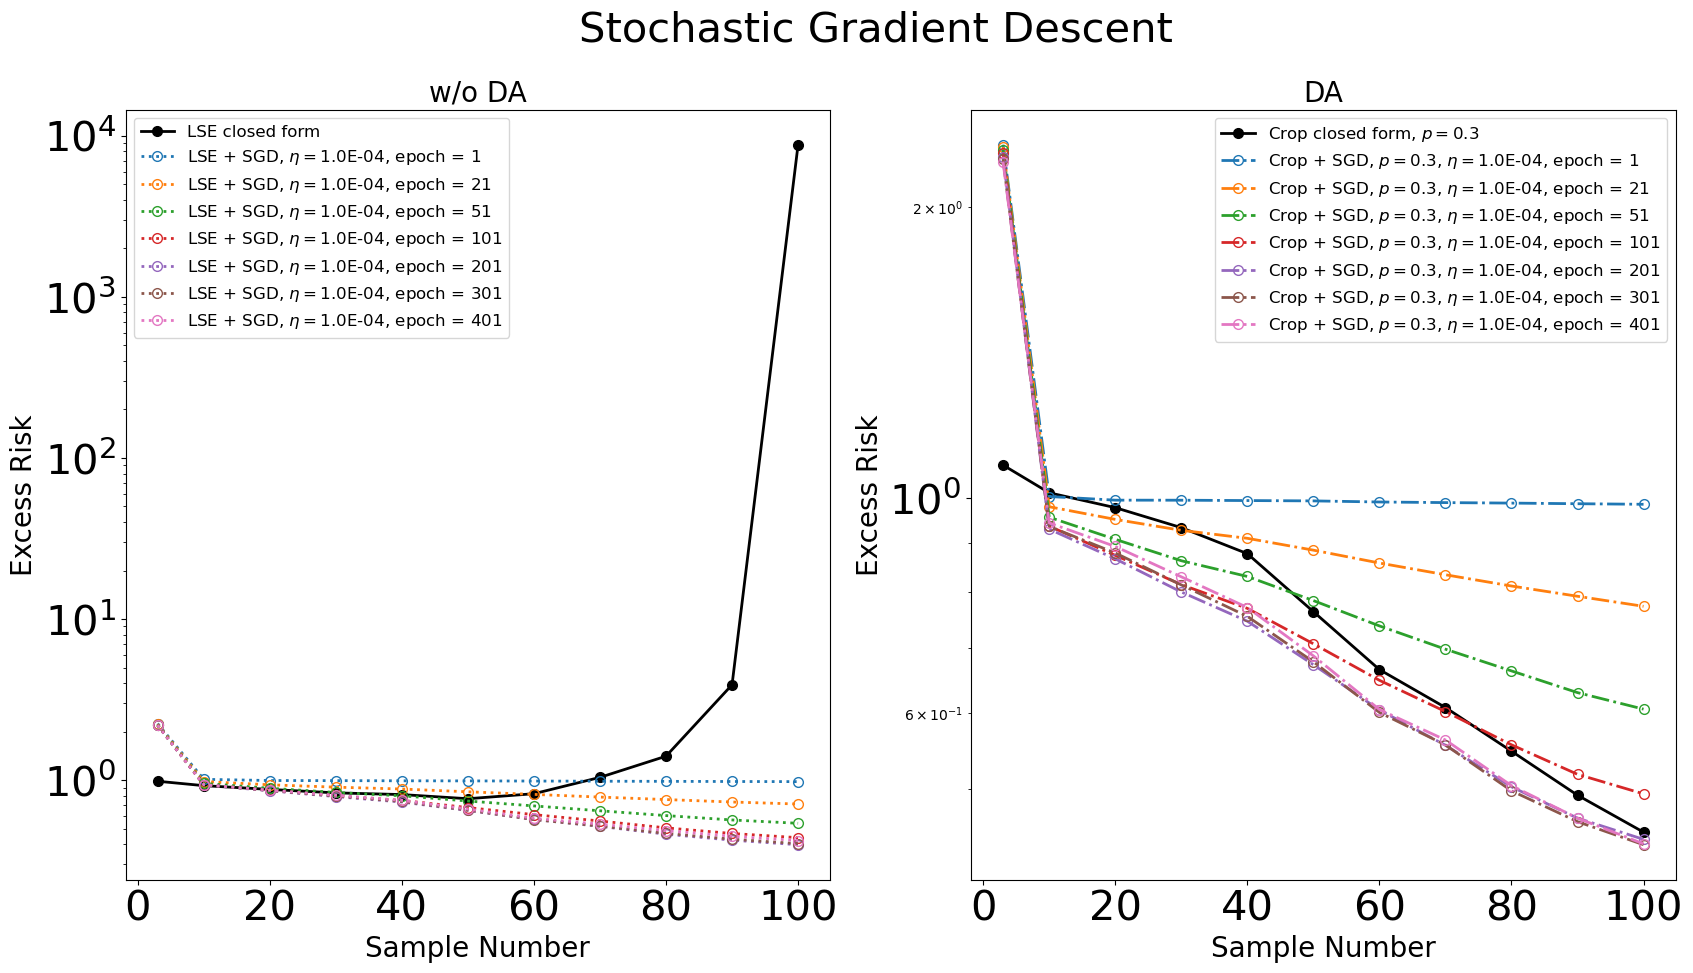

In [32]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(sample, riskLSE,label="LSE closed form", color='black', marker='o', markersize=  makersz1, linewidth=linew)
for k in [0, 20, 50, 100, 200, 300, 400]:
    plt.plot(sample, riskLSE_sgd[:, k], label=r'LSE + SGD, ' + '$\eta=$' + str(format(round(lr, 5), ".1E")) \
             + ', epoch = ' + str(k + 1), marker='o', markersize=  makersz1, linewidth=linew, ls='dotted', markerfacecolor='none') 

plt.legend(loc="upper left", prop={'size': 12})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Excess Risk', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.yscale("log")
#plt.ylim(10**-0.3,10**.6)
plt.title('w/o DA', fontsize=20)

plt.subplot(1,2,2)      
plt.plot(sample, risk_da_exp, label=r'Crop closed form, $p=$'+str(round(DA["para"],5)), marker='o', markersize=  makersz2, linewidth=linew, color='black')
for k in [0, 20, 50, 100, 200, 300, 400]:
    plt.plot(sample, risk_da_sgd[:, k], label=r'Crop + SGD, $p=$' + str(round(DA["para"],5)) + r', $\eta=$' + str(format(round(lr, 5), ".1E")) \
             + ', epoch = ' + str(k + 1), marker='o', markersize=  makersz2, linewidth=linew, ls='dashdot', markerfacecolor='none')
plt.legend(loc="upper right", prop={'size': 12})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Excess Risk', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.yscale("log")
#plt.ylim(10**-0.3,10**.6)
plt.title('DA', fontsize=20)
plt.suptitle('Stochastic Gradient Descent', fontsize=30)
plt.show()